In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPool1D, MaxPool2D, Softmax, BatchNormalization
from tensorflow.keras import Model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from umap import UMAP
import umap.plot
from umap.parametric_umap import ParametricUMAP
import flowkit as fk
import FlowCal as fc
import seaborn as sns
import bokeh
from bokeh.plotting import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
import skbio
import sys
import os
import glob
import joypy
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import hdbscan

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

main_dir = "/home/n10853499/01-projects/00-allison_microscope/"

Loading BokehJS ...

In [564]:
# glob.glob(main_dir + "reference_cultures/Pro_and_syn/*/*cus*fcs")
from sklearn.preprocessing import RobustScaler, MinMaxScaler
# df[df["FSC-A"] < 100000]

def reference_cultures(files = [main_dir + 'reference_cultures/Pro_and_syn/fixed/PFA_40_Prochlorococcus_MIT9312.fcs', main_dir + "reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_PH4_0_D8.fcs"]):
    logicle_xform = fk.transforms.AsinhTransform("asinh", param_t=262144, param_m=4.0, param_a=0.0)    
#     logicle_xform = fk.transforms.LogicleTransform("logicle", param_t=262144, param_w=0.5, param_m=4.5, param_a=0)
    # gathering the training data
    main_df = []
    labels = []
    
    strains = {}
    strain_index = 1
    
    species_map = {}
    species_index = 1
    
    exps = {0: 0, 5: 1, 15: 2, 40: 3}
    exp_index = 0
    
    for file in files:
        name = file.split("/")[-1].strip(".fcs")
        light_exp = 0
        strain = ""
        species = ""
        fixed = False
        dilution = 0

         # skip non-slow speeds
        if any(speed in name for speed in ["high", "med"]):
            continue

        # get dilution level
        if "diluted" in name:
            if "diluted heaps" in name or "diluted heap" in name:
                dilution = 2
                name = name.strip(" diluted heaps")
                name = name.strip(" diluted heap")
            else:
                dilution = 1
                name = name.strip("_diluted")
                name = name.strip(" diluted")
                    
        name = name.split("_")
        print(name)
        if "CAS85pct" in name:
            species = "Picoeukaryote"
            strain = "_".join(name[1:])
        # get light exposure and strain name
        elif "LightExp" in name or "PFA" in name:
            if "PFA" in name:
                fixed = True

            light_exp = int(name[1])
            # rename badly named files
            if name[2] == "Prochloroccocus" or name[2] == "Prochloroccocus":
                name[2] = "Prochlorococcus"
            elif name[2] == "Synecoccocus" or name[2] == "Synechoccocus":
                name[2] = "Synechococcus"
            if "MARCIA" in name:
                name[0] = "Synechococcus_MARCIA"
            strain = "_".join(name[2:])
            species = name[2]
        else:
            # rename badly named files
            if name[0] == "Prochloroccocus" or name[0] == "Prochloroccocus":
                name[0] = "Prochlorococcus"
            elif name[0] == "Synecoccocus" or name[0] == "Synechoccocus":
                name[0] = "Synechococcus"
            if "MARCIA" in name:
                name[0] = "Synechococcus_MARCIA"

            name[1] = "_".join(name[1].split(" ")).upper()
            strain = "_".join(name)
            species = name[0]
        
        print(species, strain)
        if ((strain in ["Prochlorococcus_CC9605", "Synechococcus_BBP2", "Ostreococcus_TAURI_RCC4221", "Synechococcus_CC9311", "Synechococcus_MARCIA_R1"])
            or (strain in ["Synechococcus_WH8016"] and fixed)
            # or (strain in ["Prochlorococcus_MIT9313"] and not fixed)
            or (strain in ["Prochlorococcus_NATL2A"] and light_exp == 40) 
            or (strain in ["Prochlorococcus_SS120"] and light_exp in [5, 15])
            or (strain in ["Synechococcus_MITS9220"] and light_exp in [0] and dilution in [0])): # potentially contaminated?
            continue
        
        fk_file = fk.Sample(file, subsample=50000)
        fk_file.pns_labels = fk_file.pnn_labels
#         fk_file.filter_negative_scatter(reapply_subsample=True)
        fk_file.apply_transform(logicle_xform)
        s_g1 = fc.gate.density2d(fk_file.as_dataframe(source="xform", subsample=True)[['FSC-H', 'SSC-H']].values, gate_fraction=0.75, full_output=True)
        mask = s_g1.mask
#         mask = np.array([True for _ in range(fk_file.as_dataframe(source="raw", subsample=True).shape[0])])
        df = fk_file.as_dataframe(source='xform', subsample=True)
        
        df.columns = df.columns.get_level_values(0)
        to_select = [("-A" in col or ("SC-" in col and "-W" not in col)) for col in df.columns]

        
        print("Mask: ", mask.shape, mask.sum(), mask)
        
#         mask = mask[~to_filter]
#         df = df.loc[:, to_select]
        df = df.loc[s_g1.mask, to_select]
        to_filter = scatter_filter(df.loc[:, :], use_size=True, use_iqr=True)
        print("To filter: ", to_filter.shape, to_filter.sum(), to_filter)
        # mask = np.array([mask, ~to_filter]).all(axis=0)
        mask = ~to_filter
        print("Remaining shape: ", df.loc[mask, :].shape)
#         mask = np.array([True for _ in range(df.shape[0])])
        df['fixed'] = fixed
        df['dilution'] = dilution
#         df['strain_name'] = "debris"
#         df['species'] = 0
#         df['strain'] = 0

        # convert strain to int index
        try:
            # set debris
#             df.loc[:, 'strain'] = strains[f"{strain}_debris"]
#             df.loc[:, 'strain_name'] = f"{strain}_debris"
#             df.loc[:, 'species'] = species_map[f"{species}_debris"]
            
            df.loc[mask, 'strain'] = strains[strain]
            df.loc[mask, 'strain_name'] = strain
            df.loc[mask, 'species'] = species_map[species]
        except KeyError:
            strains[strain] = strain_index
            strain_index += 1
#             strains[f"{strain}_debris"] = strain_index
#             strain_index += 1
        
#             df.loc[:, 'strain_name'] = f"{strain}_debris"
#             df.loc[:, 'strain'] = strains[f"{strain}_debris"]
            
            df.loc[mask, 'strain'] = strains[strain]
            df.loc[mask, 'strain_name'] = strain
        
        try:
#             df.loc[:, 'species'] = species_map[f"{species}_debris"]
            df.loc[mask, 'species'] = species_map[species]
        except KeyError:
            species_map[species] = species_index
            species_index += 1
#             species_map[f"{species}_debris"] = species_index
#             species_index += 1
#             df.loc[:, 'species'] = species_map[f"{species}_debris"]
            df.loc[mask, 'species'] = species_map[species]
            
        
        try:
            df['light_exp'] = exps[light_exp]
        except KeyError:
            exps[light_exp] = exp_index
            exp_index += 1
            df['light_exp'] = exps[light_exp]
        
        labels.append(df.loc[mask, ["-" not in col for col in df.columns]])
        main_df.append(df.loc[mask, ["-" in col for col in df.columns]])
#     print(main_df)
    main_df = pd.concat(main_df)
#     print(main_df)
    min_df = main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']].min()
#     min_df = main_df[['FSC-A', 'SSC-A', 'SSC-B-A']].min()
    main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] = main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] + abs(min_df)
#     main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] = main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] + abs(min_df)
    main_df.reset_index(inplace=True)
    labels = pd.concat(labels)
    labels.reset_index(inplace=True)
#     labels.pop('level_0')
#     main_df.pop('level_0')
    subsampled_df = pd.concat([main_df, labels], axis=1)
    subsampled_df = subsampled_df.groupby(['species']).sample(n=subsampled_df.groupby(['species']).count().iloc[:, 0].min())
    subsampled_df.pop('index')
#     print(subsampled_df)
    to_select = [("-A" in col or ("SC-" in col and "-W" not in col)) for col in subsampled_df.columns]
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(subsampled_df.loc[:, to_select])
    
    return scaled_df, min_df, subsampled_df

def scatter_filter(df, use_size=True, use_iqr=True, size_tolerance=2, iqr_tolerance=1.5):
    
#     print(df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean(), df[['FSC-A', 'SSC-A', 'SSC-B-A']].std())
    to_filter = np.array([False for _ in range(df.shape[0])])
    
    if use_size:
        min_a = df[['FSC-A', 'SSC-A']].min()
        min_h = df[['FSC-H', 'SSC-H']].min()
        scatter_ratio = (df[['FSC-A', 'SSC-A']].abs()).values / (df[['FSC-H', 'SSC-H']].abs() + 10e-6).values
        print(scatter_ratio.mean(axis=0))
        scatter_array = np.concatenate([scatter_ratio > size_tolerance, scatter_ratio < 1/size_tolerance], axis=1)
        print(scatter_array.sum(axis=0))
        to_filter = scatter_array.any(axis=1)

    if use_iqr:
        iqr_df = df.copy()
        iqr_df += abs(iqr_df.min())
        for col in iqr_df.columns:
            Q3 = np.quantile(iqr_df[col], 0.75)
            Q1 = np.quantile(iqr_df[col], 0.25)
            IQR = Q3 - Q1

            # print("IQR value for column %s is: %s" % (col, IQR))
            lower_range = Q1 - iqr_tolerance * IQR
            upper_range = Q3 + iqr_tolerance * IQR
            to_filter += [((x < lower_range) or (x > upper_range)) for x in iqr_df[col]]
    
    return to_filter
    
# print(glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/final/*cus*fcs") + glob.glob(main_dir + "reference_cultures/Pro_and_syn/fresh/*cus*fcs"))

In [565]:
# ref_df = reference_cultures()
s_df, min_df, unscaled_df = reference_cultures(
    glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/final/*cus*fcs") + 
    glob.glob(main_dir + "reference_cultures/Pro_and_syn/fresh/*cus*fcs") + 
    glob.glob(main_dir + "reference_cultures/Algae/final/*fcs")
)
# df, df_labels, min_df, unscaled_df = reference_cultures(glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/final/*cus*fcs")[0:15])


['PFA', '15', 'Prochlorococcus', 'CC9605']
Prochlorococcus Prochlorococcus_CC9605
['PFA', '15', 'Prochlorococcus', 'MIT9312']
Prochlorococcus Prochlorococcus_MIT9312
Mask:  (50000,) 38526 [False  True  True ...  True  True  True]
[0.97541386 1.01297808]
[ 946  196 4715    0]
To filter:  (38526,) 23334 [ True  True  True ...  True  True False]
Remaining shape:  (15192, 70)
['PFA', '15', 'Prochlorococcus', 'NATL2A']
Prochlorococcus Prochlorococcus_NATL2A
Mask:  (50000,) 37519 [False False  True ... False  True False]
[0.96717564 1.02139808]
[1070  262 5250    0]
To filter:  (37519,) 24990 [ True False  True ...  True  True False]
Remaining shape:  (12529, 70)
['PFA', '15', 'Prochlorococcus', 'SS120']
Prochlorococcus Prochlorococcus_SS120
['PFA', '15', 'Synechococcus', 'BBP1']
Synechococcus Synechococcus_BBP1
Mask:  (50000,) 37611 [ True False  True ... False  True False]
[1.50793699 1.70358509]
[ 8899 10023  3296     0]
To filter:  (37611,) 20781 [False False  True ...  True  True  True]

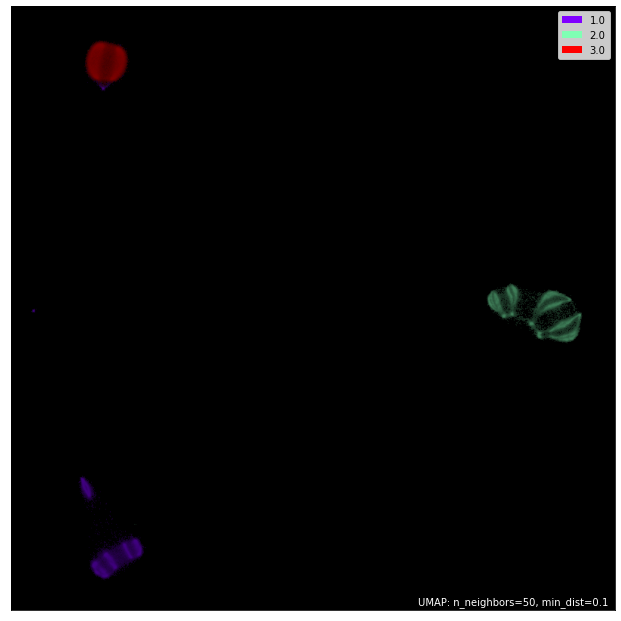

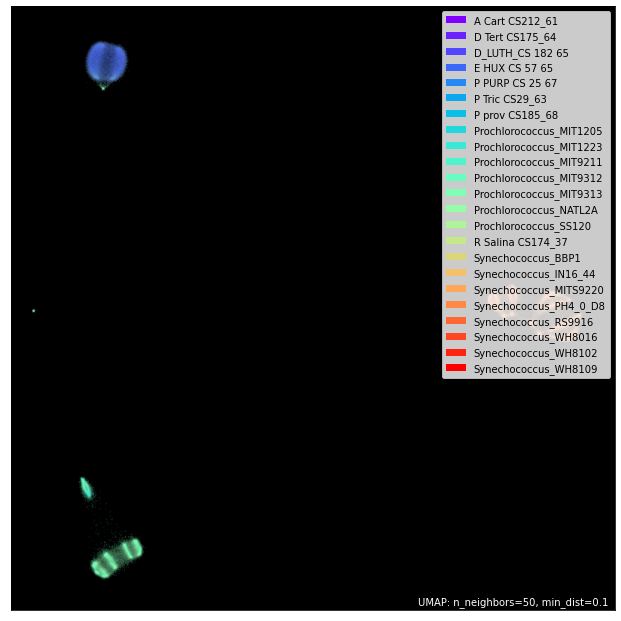

In [566]:
embedder = umap.UMAP(n_neighbors=50, a=1.48, b=0.4)
embedder.fit(s_df)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=100, gen_min_span_tree=True)
# clusterer.fit(embedder.embedding_)
umap.plot.points(embedder, labels=unscaled_df['species'], theme='fire', alpha=0.5)
plt.show()
umap.plot.points(embedder, labels=unscaled_df['strain_name'], theme='fire', alpha=1)
plt.show()

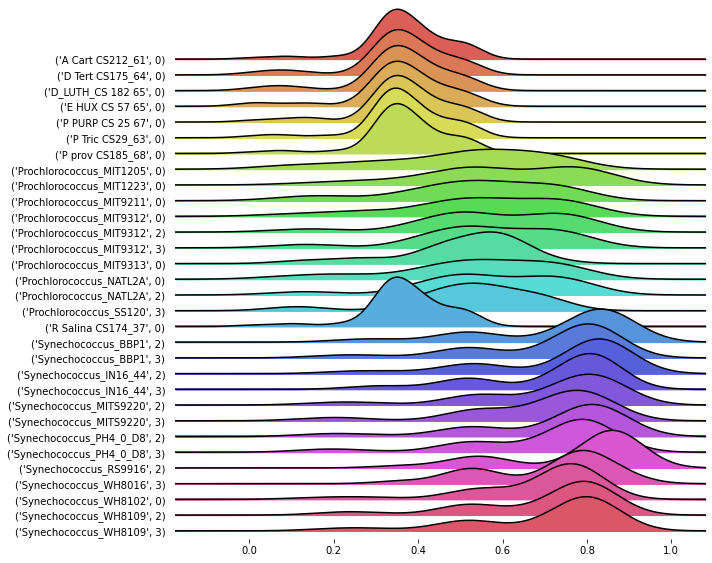

'Synechococcus_MITS9220'

In [567]:
# df_labels['strain'].unique().shape[0]
# # np.isnan(df).any()
# df_labels['strain'].unique()
# pd.concat([unscaled_df, df_labels['strain']], axis=1).groupby('strain').mean().transpose()
# pd.DataFrame(df)
# pd.concat([pd.DataFrame(df), df_labels['strain'].reset_index()], axis=1)
# pd.concat([pd.DataFrame(df), df_labels[['strain_name', 'dilution', 'light_exp']].reset_index()], axis=1).drop("index", axis=1).groupby(['strain_name', 'dilution', 'light_exp']).mean().transpose()
# import seaborn as sns
joy_df = pd.concat([pd.DataFrame(s_df), unscaled_df[['strain_name', 'light_exp']].reset_index()], axis=1).drop("index", axis=1).groupby(['strain_name', 'light_exp']).mean().transpose()
joypy.joyplot(joy_df, figsize=(10, 8), labels=joy_df.columns.get_level_values(0), color=sns.color_palette("hls", len(joy_df.columns.get_level_values(0))))
plt.show()
"Synechococcus_MITS9220"

# Remove every debris except 0 0

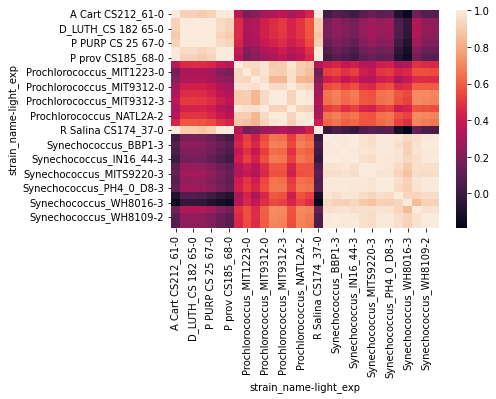

In [538]:
sns.heatmap(joy_df.corr())
plt.show()

In [568]:
unscaled_df.groupby(['species', 'strain_name', 'light_exp', 'dilution']).count()

pnn                                                 UV1-A  UV2-A  UV3-A  \
species strain_name             light_exp dilution                        
1.0     Prochlorococcus_MIT1205 0         0          2093   2093   2093   
        Prochlorococcus_MIT1223 0         0          9235   9235   9235   
        Prochlorococcus_MIT9211 0         0          5162   5162   5162   
        Prochlorococcus_MIT9312 0         0          5794   5794   5794   
                                2         0         28655  28655  28655   
                                3         0         25163  25163  25163   
        Prochlorococcus_MIT9313 0         0         11702  11702  11702   
        Prochlorococcus_NATL2A  0         0          4925   4925   4925   
                                2         0         23499  23499  23499   
        Prochlorococcus_SS120   3         0         16730  16730  16730   
2.0     Synechococcus_BBP1      2         0         12267  12267  12267   
                                3         0          4277   4277   4277   
                                          1          5934   5934   5934   
        Synechococcus_IN16_44   2         0          6239   6239   6239   
                                          1          7408   7408   7408   
                                3         0          4301   4301   4301   
                                          1          5843   5843   5843   
        Synechococcus_MITS9220  2         0         14671  14671  14671   
                                3         0         12302  12302  12302   
        Synechococcus_PH4_0_D8  2         0          5658   5658   5658   
                                          1          6303   6303   6303   
                                3         0          3149   3149   3149   
                                          2          5439   5439   5439   
        Synechococcus_RS9916    2         0         14056  14056  14056   
        Synechococcus_WH8016    3         0          2395   2395   2395   
        Synechococcus_WH8102    0         0          1713   1713   1713   
        Synechococcus_WH8109    2         0         11256  11256  11256   
                                3         0          3534   3534   3534   
                                          1          6213   6213   6213   
3.0     A Cart CS212_61         0         0         19102  19102  19102   
        D Tert CS175_64         0         0         15440  15440  15440   
        D_LUTH_CS 182 65        0         0         15306  15306  15306   
        E HUX CS 57 65          0         0         14730  14730  14730   
        P PURP CS 25 67         0         0         15565  15565  15565   
        P Tric CS29_63          0         0         16437  16437  16437   
        P prov CS185_68         0         0         17223  17223  17223   
        R Salina CS174_37       0         0         19155  19155  19155   

pnn                                                 UV4-A  UV5-A  UV6-A  \
species strain_name             light_exp dilution                        
1.0     Prochlorococcus_MIT1205 0         0          2093   2093   2093   
        Prochlorococcus_MIT1223 0         0          9235   9235   9235   
        Prochlorococcus_MIT9211 0         0          5162   5162   5162   
        Prochlorococcus_MIT9312 0         0          5794   5794   5794   
                                2         0         28655  28655  28655   
                                3         0         25163  25163  25163   
        Prochlorococcus_MIT9313 0         0         11702  11702  11702   
        Prochlorococcus_NATL2A  0         0          4925   4925   4925   
                                2         0         23499  23499  23499   
        Prochlorococcus_SS120   3         0         16730  16730  16730   
2.0     Synechococcus_BBP1      2         0         12267  12267  12267   
                                3         0          4277   4277   4277   
                        

In [572]:
x_train, x_test, y_train, y_test = train_test_split(s_df, unscaled_df['species'] - 1)
print(x_train.shape)

(299155, 70)


In [174]:
x_train

array([[0.30016325, 0.3836219 , 0.05572136, ..., 0.91505794, 0.91851337,
        0.90997056],
       [0.15361287, 0.696217  , 0.64413165, ..., 0.63289537, 0.53523722,
        0.55491076],
       [0.37347504, 0.82655659, 0.66806148, ..., 0.16309994, 0.43513526,
        0.23506107],
       ...,
       [0.74210995, 0.83976275, 0.38919483, ..., 0.33085397, 0.16927019,
        0.20716409],
       [0.71531846, 0.32789149, 0.77929448, ..., 0.7165132 , 0.66221059,
        0.63220946],
       [0.23732876, 0.28833274, 0.79763679, ..., 0.63664206, 0.69772432,
        0.69790148]])

In [ ]:
dims1 = (70, 1)
dims2 = (70, )
class FlowCytoModel(Model):
  def __init__(self, checkpoint_path = './flow_cyto_species_selector'):
    super(FlowCytoModel, self).__init__()
    self.model = models.Sequential()
#     self.model.add(Dense(70, activation='relu', input_shape=dims1))

    input_layer = Conv1D(filters=16, kernel_size=3, strides=(1), padding="same", input_shape=dims1, activation='relu')
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    self.model.add(input_layer + noise)
    
    self.model.add(Conv1D(filters=32, kernel_size=3, strides=(1), padding="same", activation='relu'))
#     self.model.add(Conv1D(filters=67, kernel_size=2, strides=(1), padding="same", activation='relu'))
    self.model.add(MaxPool1D(strides=2, pool_size=2))

#     self.model.add(Conv1D(filters=32, kernel_size=5, strides=(1), activation='relu', padding="same"))
    self.model.add(Conv1D(filters=64, kernel_size=5, strides=(1), activation='relu', padding="same"))
    self.model.add(Conv1D(filters=128, kernel_size=5, strides=(1), activation='relu', padding="same"))
    self.model.add(MaxPool1D(strides=2, pool_size=2))
    
#     self.model.add(Conv1D(filters=175, kernel_size=2, strides=(1), activation='relu', padding="same"))
# #     self.model.add(Conv1D(filters=245, kernel_size=2, strides=(1), activation='relu'))
#     self.model.add(MaxPool1D(strides=2, pool_size=1))
#     self.model.add(Conv1D(filters=64, kernel_size=7, strides=(1), activation='relu', padding="same"))
    self.model.add(Conv1D(filters=256, kernel_size=7, strides=(1), activation='relu', padding="same"))
    self.model.add(Conv1D(filters=512, kernel_size=7, strides=(1), activation='relu', padding="same"))
    self.model.add(MaxPool1D(strides=2, pool_size=2))
    
#     self.model.add(Conv1D(filters=220, kernel_size=4, strides=(1), activation='relu', padding="same"))
#     self.model.add(MaxPool1D(strides=4, pool_size=1))
    
    self.model.add(Flatten())
#     self.model.add(Dense(70, activation='relu', input_shape=dims))
#     self.model.add(Dense(256, activation='relu'))
#     self.model.add(Dense(128, activation='relu'))

#     self.model.add(Dense(70, activation='relu'))
#     self.model.add(Dense(64, activation='relu'))
#     self.model.add(Dense(35, activation='relu'))
#     self.model.add(Dense(unscaled_df['species'].unique().shape[0] * 4, activation='relu'))
#     self.model.add(Dense(unscaled_df['species'].unique().shape[0] * 2, activation='relu'))
    self.model.add(Dense(unscaled_df['species'].unique().shape[0], activation='softmax'))
#     self.model.add(Softmax())
    # Create a callback that saves the model's weights
    self.cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
#     self.model.compile(optimizer='sgd',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])
    
    self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

  def fit(self, train_images, train_labels, validation, epochs=10, batch_size=32):
    history = self.model.fit(train_images, train_labels, epochs=epochs, 
                             validation_data=validation, use_multiprocessing=False, callbacks=[self.cp_callback])

    return history
    
  def summary(self):
    self.model.summary()

# Create an instance of the model
model = FlowCytoModel()
# model.model.build()
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_155 (Conv1D)         (None, 70, 16)            64        
                                                                 
 conv1d_156 (Conv1D)         (None, 70, 32)            1568      
                                                                 
 max_pooling1d_79 (MaxPoolin  (None, 35, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_157 (Conv1D)         (None, 35, 64)            10304     
                                                                 
 conv1d_158 (Conv1D)         (None, 35, 128)           41088     
                                                                 
 max_pooling1d_80 (MaxPoolin  (None, 17, 128)          0         
 g1D)                                                

In [574]:
model.fit(x_train, y_train, (x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
9338/9349 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9982
Epoch 1: saving model to ./flow_cyto_species_selector
9349/9349 [==============================] - 37s 4ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 2/10
9339/9349 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995
Epoch 2: saving model to ./flow_cyto_species_selector
9349/9349 [==============================] - 35s 4ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 3/10
9346/9349 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 3: saving model to ./flow_cyto_species_selector
9349/9349 [==============================] - 35s 4ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 4/10
9343/9349 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9996
Epoch 4: saving model to ./flow_cyto_species

In [60]:
!mkdir -p flow_cyto_model

In [575]:
model.model.save('flow_cyto_model/flow_cyto_species_selector')
saved_model = tf.keras.models.load_model('flow_cyto_model/flow_cyto_species_selector')
# Evaluate the model
saved_model.summary()
loss, acc = saved_model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


INFO:tensorflow:Assets written to: flow_cyto_model/flow_cyto_species_selector/assets
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_155 (Conv1D)         (None, 70, 16)            64        
                                                                 
 conv1d_156 (Conv1D)         (None, 70, 32)            1568      
                                                                 
 max_pooling1d_79 (MaxPoolin  (None, 35, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_157 (Conv1D)         (None, 35, 64)            10304     
                                                                 
 conv1d_158 (Conv1D)         (None, 35, 128)           41088     
                                                                 
 max_pooling1d_80 (MaxPoolin  (Non

In [588]:
def read_transect_data(paths=None, minima=min_df):
#     logicle_xform = fk.transforms.LogicleTransform("logicle", param_t=262144, param_w=0.5, param_m=4.5, param_a=0)
    logicle_xform = fk.transforms.AsinhTransform("asinh", param_t=262144, param_m=4.0, param_a=0.0)    
    scaler = MinMaxScaler()
    # gathering the training data
    main_df = []
    main_df_labels = []
    sample_idx = 0
    for file in paths:
        print(f"Processing {file}")
        if "fcs" not in file: 
            print(f"Skipping {file}")
            continue
        
        name = file.split("/")[-1].strip(".fcs")
        
        if any([check in name.lower() for check in ["test", "beads"]]): 
            print(f"Skipping {file}")
            continue
        
        fk_file = fk.Sample(file, subsample=25000)
        fk_file.pns_labels = fk_file.pnn_labels
        fk_file.apply_transform(logicle_xform)
#         s_g1 = fc.gate.density2d(fk_file.as_dataframe(source="xform", subsample=True)[['FSC-H', 'SSC-H']].values, gate_fraction=0.99, full_output=True)
        df = fk_file.as_dataframe(source='xform', subsample=True)
        df.columns = df.columns.get_level_values(0)
        to_select = [("-A" in col or ("SC-" in col and "-W" not in col)) for col in df.columns]
        
        to_filter = scatter_filter(df, use_iqr=False, size_tolerance=3)
        mask = to_filter
        df = df.loc[~mask, to_select]
        df['sample'] = name.lower().replace(" ", "_")
        df['sample_idx'] = sample_idx
        df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] = df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] + abs(minima)
        sample_idx += 1
        scaled_df = scaler.fit_transform(df.loc[:, ["-" in col for col in df.columns]])
        
        main_df.append(scaled_df)
        main_df_labels.append(df.loc[:, ["-" not in col for col in df.columns]])

    main_df = np.concatenate(main_df, axis=0)
#     min_df = main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']].min()
#     min_df = main_df[['FSC-A', 'SSC-A', 'SSC-B-A']].min()
#     main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] = main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] + abs(minima)
#     main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] = main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] + abs(min_df)
    
    
    
    labels = pd.concat(main_df_labels)
    labels['transect_label'] = labels['sample'].apply(lambda s: int(s.split("_")[2].strip('ft')))
    labels.reset_index(inplace=True)
#     main_df.reset_index(inplace=True)
    return main_df, labels
    

In [589]:
transect_data, transect_labels = read_transect_data(
    glob.glob(main_dir + "/transect_data/trimmed/*.fcs")[0:1],
    min_df
)

Processing /home/n10853499/01-projects/00-allison_microscope//transect_data/trimmed/IN16_01 FT01 20210907 phyto.fcs
[3.07449814 0.9829234 ]
[1691    8 2312    3]


In [558]:
transect_data.shape

(10730, 70)

In [107]:
len(glob.glob(main_dir + "/transect_data/trimmed/*.fcs"))

30

In [591]:
predictions = saved_model.predict(transect_data)
predictions = pd.DataFrame(predictions)
predictions
print(predictions.sum(axis=0))

0    11773.793945
1     1538.701416
2      225.670578
dtype: float32


In [584]:
print(predictions.sum(axis=0))
# unscaled_df.groupby(['species', 'strain_name']).count()
# predictions.apply('max', axis=1)
# max_weight[max_weight.isnull()]

0    3088.486816
1      24.078814
2      10.442058
dtype: float32


In [611]:
labels = predictions.apply('idxmax', axis=1)
max_weight = predictions.apply('max', axis=1)
transect_labels['species_prediction'] = labels + 1
# print(max_weight)
transect_labels['max_weight'] = max_weight
# print(transect_labels.shape)
weight_cols = [f'weight{i}' for i in range(predictions.shape[1])]
transect_labels[weight_cols] = predictions

# transect_labels.loc[transect_labels['max_weight'] < 0.8, 'species_prediction'] = 0
transect_labels['Debris'] = np.array([embedder_transect.embedding_[:, 0] < 0, embedder_transect.embedding_[:, 1] < 10]).all(axis=0)
transect_labels['Pro'] = np.array([embedder_transect.embedding_[:, 0] > 10, embedder_transect.embedding_[:, 1] < 10]).all(axis=0)
transect_labels['Syn'] = np.array([embedder_transect.embedding_[:, 0] < 5, embedder_transect.embedding_[:, 1] > 10]).all(axis=0)
print(transect_labels)

pnn    index                       sample  sample_idx  transect_label  \
0          0  in16_01_ft01_20210907_phyto           0               1   
1          1  in16_01_ft01_20210907_phyto           0               1   
2          2  in16_01_ft01_20210907_phyto           0               1   
3          3  in16_01_ft01_20210907_phyto           0               1   
4          5  in16_01_ft01_20210907_phyto           0               1   
...      ...                          ...         ...             ...   
13533  17543  in16_01_ft01_20210907_phyto           0               1   
13534  17544  in16_01_ft01_20210907_phyto           0               1   
13535  17545  in16_01_ft01_20210907_phyto           0               1   
13536  17546  in16_01_ft01_20210907_phyto           0               1   
13537  17547  in16_01_ft01_20210907_phyto           0               1   

pnn    species_prediction  max_weight   weight0       weight1       weight2  \
0                       1    1.000000  1.000

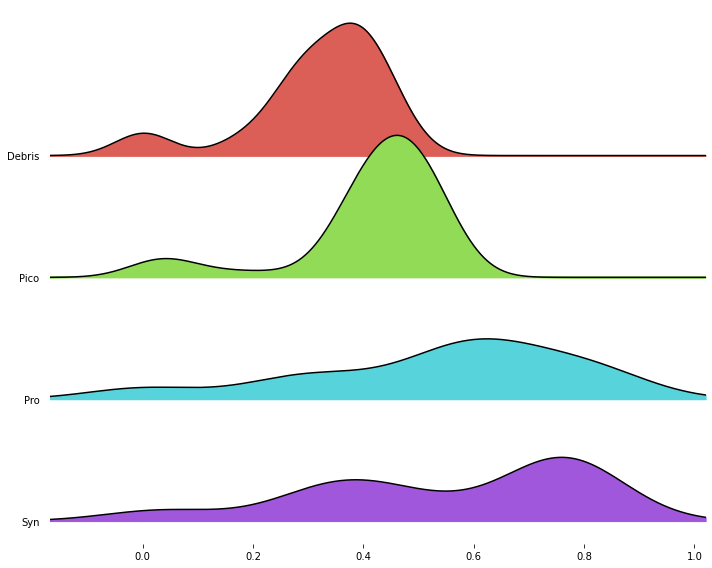

In [621]:
transect_joy_df = pd.concat([pd.DataFrame(transect_data), transect_labels[['Truth']].reset_index()], axis=1).drop("index", axis=1).groupby(['Truth']).mean().transpose()
joypy.joyplot(transect_joy_df, figsize=(10, 8), labels=transect_joy_df.columns.get_level_values(0), color=sns.color_palette("hls", len(transect_joy_df.columns.get_level_values(0))))
plt.show()

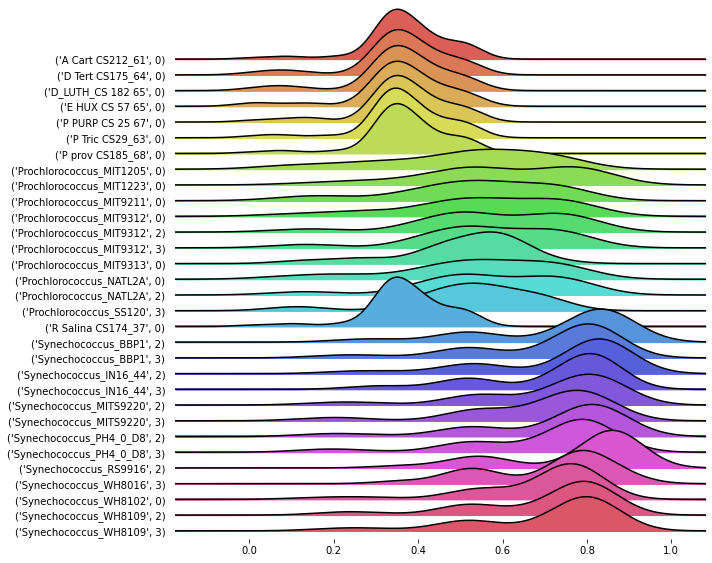

In [620]:
joypy.joyplot(joy_df, figsize=(10, 8), labels=joy_df.columns.get_level_values(0), color=sns.color_palette("hls", len(joy_df.columns.get_level_values(0))))
plt.show()

In [618]:
transect_labels.groupby(['Pro', 'Syn', 'Debris']).count()
transect_labels['Truth'] = 'Pico'
transect_labels['Truth'].iloc[transect_labels['Debris'] == True] = 'Debris'
transect_labels['Truth'].iloc[transect_labels['Pro'] == True] = 'Pro'
transect_labels['Truth'].iloc[transect_labels['Syn'] == True] = 'Syn'

/tmp/ipykernel_21023/537183392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transect_labels['Truth'].iloc[transect_labels['Debris'] == True] = 'Debris'
/tmp/ipykernel_21023/537183392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transect_labels['Truth'].iloc[transect_labels['Pro'] == True] = 'Pro'
/tmp/ipykernel_21023/537183392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transect_labels['Truth'].iloc[transect_label

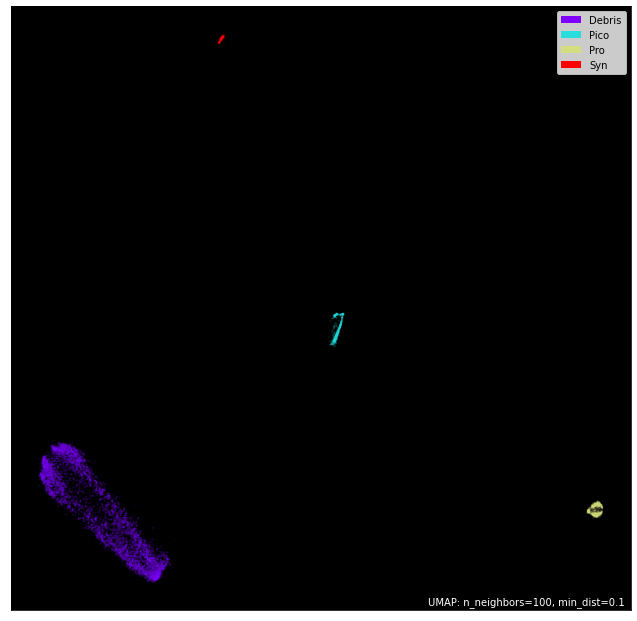

In [619]:
# embedder_transect = umap.UMAP(n_neighbors=100, a=1.48, b=0.4)
# embedder_transect.fit(transect_data)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=100, gen_min_span_tree=True)
# clusterer.fit(embedder.embedding_)
umap.plot.points(embedder_transect, labels=transect_labels['Truth'], theme="fire", alpha=0.1)
plt.show()

In [597]:
embedder_transect.embedding_[np.array([embedder_transect.embedding_[:, 0] < 0, embedder_transect.embedding_[:, 1] < 0]).all(axis=0)]

array([[-3.585818 , -1.7959075],
       [-1.4834039, -1.4314218],
       [-3.5285885, -1.6132436],
       ...,
       [-1.8952914, -2.3438118],
       [-3.3120542, -1.9789017],
       [-2.58601  , -1.5993583]], dtype=float32)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


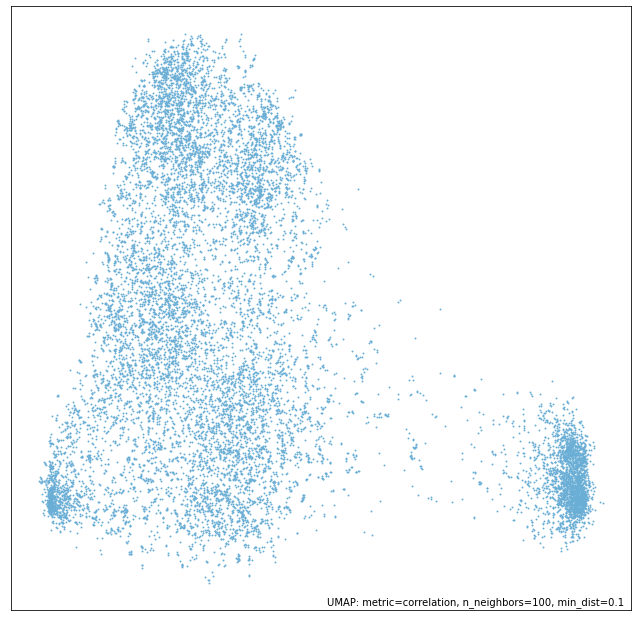

In [609]:
embedder = umap.UMAP(n_neighbors=100, a=1.48, b=0.4, metric='correlation')
embedder.fit(transect_data[transect_labels['species_prediction'] == 0, :])
# embedder.fit(transect_data)
umap.plot.points(embedder)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


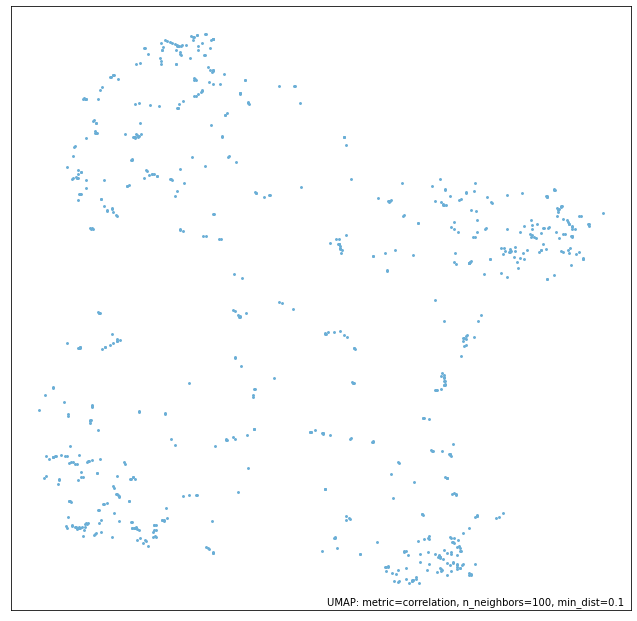

In [865]:
embedder = umap.UMAP(n_neighbors=100, a=1.48, b=0.4, metric='correlation')
embedder.fit(transect_data[transect_labels['species_prediction'] == 1, :])
# embedder.fit(transect_data)
umap.plot.points(embedder)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


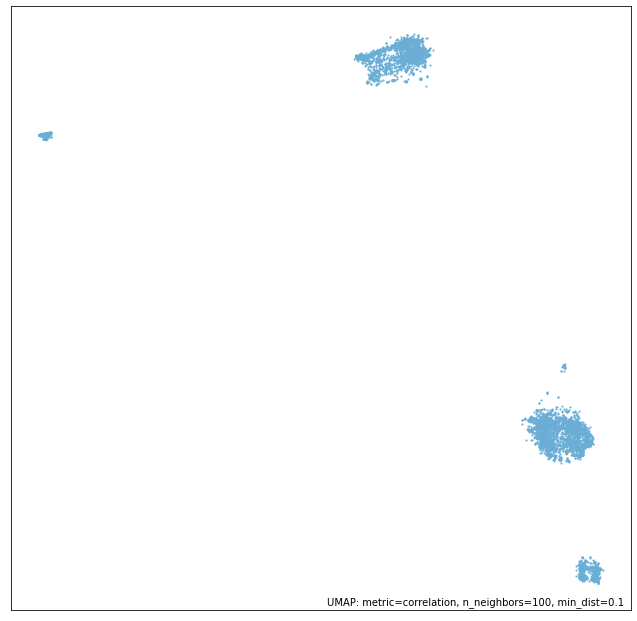

In [983]:
embedder = umap.UMAP(n_neighbors=100, a=1.48, b=0.4, metric='correlation')
embedder.fit(transect_data[transect_labels['species_prediction'] == 2, :])
# embedder.fit(transect_data)
umap.plot.points(embedder)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


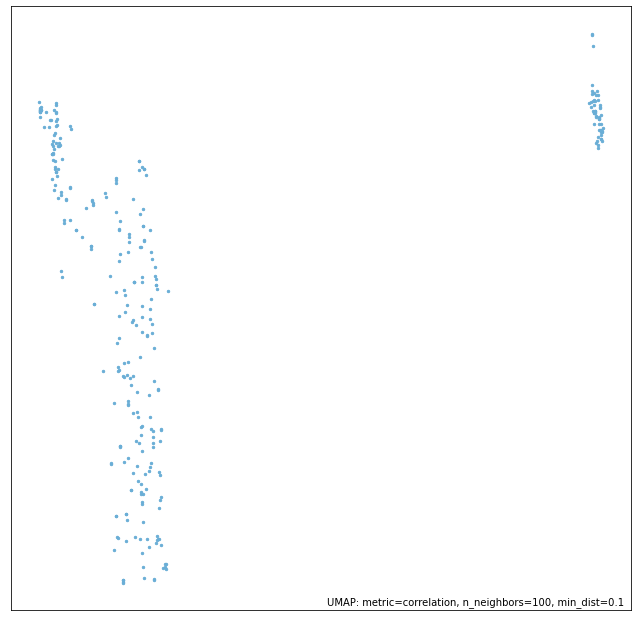

In [597]:
embedder = umap.UMAP(n_neighbors=100, a=1.48, b=0.4, metric='correlation')
embedder.fit(transect_data[transect_labels['species_prediction'] == 3, :])
# embedder.fit(transect_data)
umap.plot.points(embedder)
plt.show()

In [362]:
(transect_labels['species_prediction'] == 1) & (transect_labels['sample_idx'] > 20)

0        False
1        False
2        False
3        False
4        False
         ...  
24995     True
24996    False
24997    False
24998     True
24999     True
Length: 717548, dtype: bool

In [631]:
print(transect_data[(transect_labels['species_prediction'] == 0) & (transect_labels['transect_label'] < 20), :].shape)
print(transect_data[(transect_labels['species_prediction'] == 1) & (transect_labels['transect_label'] < 20), :].shape)
print(transect_data[(transect_labels['species_prediction'] == 2) & (transect_labels['transect_label'] < 20), :].shape)
print(transect_data[(transect_labels['species_prediction'] == 3) & (transect_labels['transect_label'] < 20), :].shape)

(4117, 70)
(1200, 70)
(7098, 70)
(5133, 70)


In [375]:
90936 / 4616

19.700173310225303

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


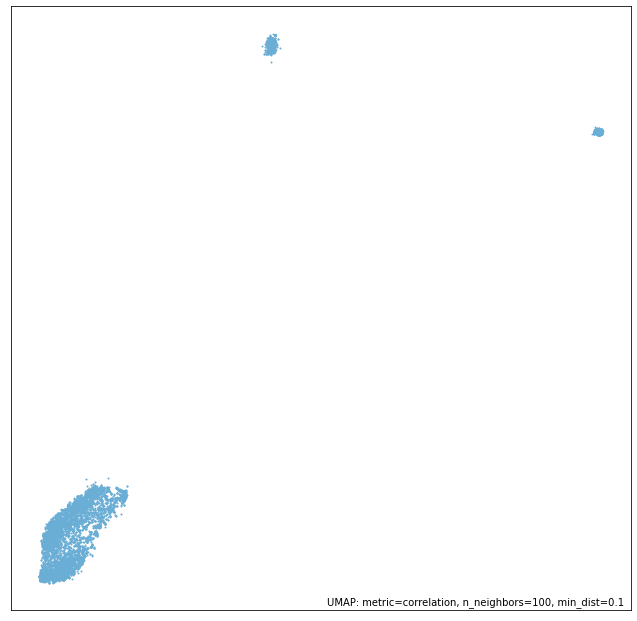

In [319]:
test_df = test.as_dataframe(source="xform", subsample=True)
test_df = test_df.loc[:, ["-" in col and "-W" not in col for col in test_df.columns.get_level_values(0)]]
# Need to divide scatter 
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(test_df)
    
embedder = umap.UMAP(n_neighbors=100, a=1.48, b=0.4, metric='correlation')
embedder.fit(scaled_df)
umap.plot.points(embedder)
plt.show()

In [118]:
predictions.shape

(1605016, 4)

In [100]:
test_df = test.as_dataframe(source="xform")
test_df.columns.get_level_values(0)

Index(['Time', 'UV1-A', 'UV2-A', 'UV3-A', 'UV4-A', 'UV5-A', 'UV6-A', 'UV7-A',
       'UV8-A', 'UV9-A', 'UV10-A', 'UV11-A', 'UV12-A', 'UV13-A', 'UV14-A',
       'UV15-A', 'UV16-A', 'SSC-W', 'SSC-H', 'SSC-A', 'V1-A', 'V2-A', 'V3-A',
       'V4-A', 'V5-A', 'V6-A', 'V7-A', 'V8-A', 'V9-A', 'V10-A', 'V11-A',
       'V12-A', 'V13-A', 'V14-A', 'V15-A', 'V16-A', 'FSC-W', 'FSC-H', 'FSC-A',
       'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'B1-A', 'B2-A', 'B3-A', 'B4-A', 'B5-A',
       'B6-A', 'B7-A', 'B8-A', 'B9-A', 'B10-A', 'B11-A', 'B12-A', 'B13-A',
       'B14-A', 'YG1-A', 'YG2-A', 'YG3-A', 'YG4-A', 'YG5-A', 'YG6-A', 'YG7-A',
       'YG8-A', 'YG9-A', 'YG10-A', 'R1-A', 'R2-A', 'R3-A', 'R4-A', 'R5-A',
       'R6-A', 'R7-A', 'R8-A'],
      dtype='object', name='pnn')

In [318]:
# test = fk.Sample(main_dir + "reference_cultures/Pro_and_syn/fresh/LightExp_40_Synechococcus_MARCIA_R1.fcs")
# test = fk.Sample(main_dir + "reference_cultures/Pro_and_syn/fresh/LightExp_15_Prochlorococcus_NATL2A.fcs")
# test = fk.Sample(main_dir + "reference_cultures/Algae/CAS85pct_D_LUTH_CS 182 65.fcs")
# test = fk.Sample(main_dir + "reference_cultures/Algae/CAS85pct_E HUX CS 57 65.fcs")
test = fk.Sample(glob.glob(main_dir + "/transect_data/trimmed/*.fcs")[0])

test.pns_labels = test.pnn_labels
# test.filter_negative_scatter()

logicle_xform = fk.transforms.LogicleTransform("logicle", param_t=262144, param_w=0.5, param_m=4.5, param_a=0)
test.apply_transform(logicle_xform)


# p = test.plot_scatter('FSC-H', 'SSC-H', source='xform')
# show(p)
# plt.show()

In [641]:
test.channels

channel_number    pnn pns  png         pne        pnr
0                1   Time      1.0  (0.0, 0.0)  2173183.0
1                2  UV1-A      1.0  (0.0, 0.0)  4194304.0
2                3  UV2-A      1.0  (0.0, 0.0)  4194304.0
3                4  UV3-A      1.0  (0.0, 0.0)  4194304.0
4                5  UV4-A      1.0  (0.0, 0.0)  4194304.0
..             ...    ...  ..  ...         ...        ...
66              67   R4-A      1.0  (0.0, 0.0)  4194304.0
67              68   R5-A      1.0  (0.0, 0.0)  4194304.0
68              69   R6-A      1.0  (0.0, 0.0)  4194304.0
69              70   R7-A      1.0  (0.0, 0.0)  4194304.0
70              71   R8-A      1.0  (0.0, 0.0)  4194304.0

[71 rows x 6 columns]

In [645]:
spm = test.plot_scatter_matrix(
    source='xform',
    channel_labels_or_numbers=['FSC-H', 'SSC-H', 'UV1-A', 'YG1-A'],
    color_density=True
)
show(spm)

False


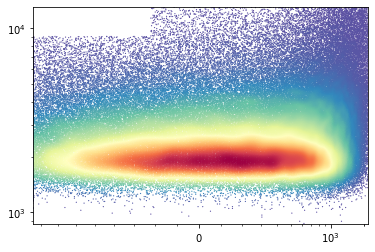

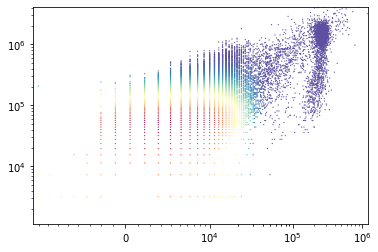

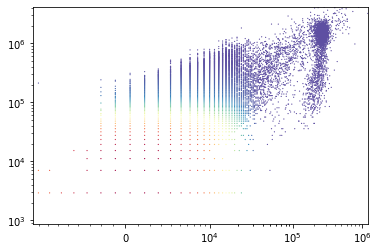

In [205]:
s_g1 = fc.gate.density2d(test.as_dataframe(source="xform")[['FSC-A', 'SSC-A']].values, gate_fraction=0.7, full_output=True)
print(s_g1.mask.all())
fc.plot.density2d(test.as_dataframe(source="xform")[['FSC-A', 'SSC-A']].values[s_g1.mask, :],
                        mode='scatter')
plt.show()

fc.plot.density2d(test.as_dataframe(source="xform")[['FSC-A', 'SSC-A']].values[~s_g1.mask, :],
                        mode='scatter')
plt.show()

fc.plot.density2d(test.as_dataframe(source="xform")[['FSC-A', 'SSC-A']].values[:, :],
                        mode='scatter')
plt.show()

In [206]:
s_g1.mask.shape

(245616,)

In [346]:
# test_df = test.as_dataframe(source="raw")
# scaler = MinMaxScaler()
# test_df[['FSC-A', 'SSC-A', 'SSC-B-A']] = scaler.fit_transform(test_df[['FSC-A', 'SSC-A', 'SSC-B-A']])
greater_than_min = (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']] > (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean() - test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].std() * 1.5)).values.all(axis=1)
less_than_max = (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']] < (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean() + test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].std() * 1.5)).values.all(axis=1)

np.array([greater_than_min, less_than_max]).all(axis=0)

array([ True,  True,  True, ...,  True,  True,  True])

In [148]:
print(df.columns.get_level_values(0))
df.columns = df.columns.get_level_values(0)
to_select = ["-A" in col for col in df.columns]

to_select[0] = True
df_select = df.loc[:, to_select]
df_select['fixed'] = True
df_select.reset_index(drop=True, inplace=True)
# df.drop("index",axis=1,inplace=True)
df_select.values

Index(['UV1-A', 'UV2-A', 'UV3-A', 'UV4-A', 'UV5-A', 'UV6-A', 'UV7-A', 'UV8-A',
       'UV9-A', 'UV10-A', 'UV11-A', 'UV12-A', 'UV13-A', 'UV14-A', 'UV15-A',
       'UV16-A', 'SSC-A', 'V1-A', 'V2-A', 'V3-A', 'V4-A', 'V5-A', 'V6-A',
       'V7-A', 'V8-A', 'V9-A', 'V10-A', 'V11-A', 'V12-A', 'V13-A', 'V14-A',
       'V15-A', 'V16-A', 'FSC-A', 'SSC-B-A', 'B1-A', 'B2-A', 'B3-A', 'B4-A',
       'B5-A', 'B6-A', 'B7-A', 'B8-A', 'B9-A', 'B10-A', 'B11-A', 'B12-A',
       'B13-A', 'B14-A', 'YG1-A', 'YG2-A', 'YG3-A', 'YG4-A', 'YG5-A', 'YG6-A',
       'YG7-A', 'YG8-A', 'YG9-A', 'YG10-A', 'R1-A', 'R2-A', 'R3-A', 'R4-A',
       'R5-A', 'R6-A', 'R7-A', 'R8-A', 'strain', 'fixed', 'dilution',
       'light_exp'],
      dtype='object', name='pnn')


/tmp/ipykernel_83551/1028801468.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['fixed'] = True


array([[-0.0735066804936676, 0.35675042791370065, -0.03932611264930608,
        ..., 0.5749212251222804, 0.5201491382502402, True],
       [0.3920623135395697, -0.03617378124476439, -0.14020916996416288,
        ..., 0.5797394964500261, 0.5596647313716516, True],
       [0.03962985966083046, 0.4068964097238054, -0.1613455826954463,
        ..., -0.07325642064454685, 0.40251426427317966, True],
       ...,
       [0.3651167987234976, 0.26703681374296917, -0.0631848715479158,
        ..., 0.40541023129336323, -0.0757653715959406, True],
       [0.3651167987234976, 0.35399952810135166, 0.34968594598725145,
        ..., 0.525096802782412, 0.42978855449098063, True],
       [0.35058210531978146, 0.37846808439196533, 0.3969216005542904,
        ..., 0.5896740336520798, 0.5119655536195964, True]], dtype=object)

In [47]:
print(y_train)

151055    1
269479    1
129146    1
259902    4
133535    0
         ..
69646     4
488636    2
489985    2
15363     2
477602    0
Name: strain, Length: 940485, dtype: int64


In [59]:
from ivis import Ivis

# embedder = UMAP(n_components=2, n_neighbors=100)
# embedder.fit(df)
# print(y_train)

# ivis_embedder = Ivis(n_epochs_without_progress=5)
# ivis_embedder.fit(x_train)
ivis_embedding = ivis_embedder.transform(x_train)

7348/7348 [==============================] - 6s 730us/step


In [70]:
ivis_embedding

array([[-12.615425  ,   0.7372441 ],
       [ -9.287775  ,  -1.4827724 ],
       [  2.1869824 ,   2.747534  ],
       ...,
       [-12.816337  ,  -6.194436  ],
       [  0.13998838,   1.4032309 ],
       [  0.15816058,  -1.1295582 ]], dtype=float32)

[1 1 1 ... 2 2 0]


/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


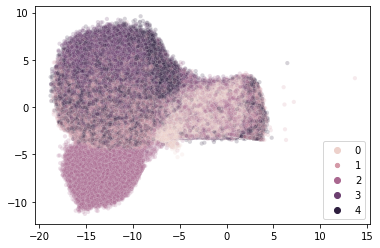

In [72]:
# umap.plot.points(embedder, labels = df_labels.values[:, 0], background='black')
# plt.show()
import seaborn as sns
print(y_train.values)
sns.scatterplot(ivis_embedding[:, 0], ivis_embedding[:, 1], y_train.values, size=1, alpha=0.2)
plt.show()

In [56]:
print(set(df_labels.values[:, 0]))
print(glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/*cus*fcs")[0:5])

from ivis import Ivis
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

tf.config.optimizer.set_jit(
    False
)

iris = datasets.load_iris()

X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target)
X = iris.data

# Scale the data to [0, 1]
X_scaled = MinMaxScaler().fit_transform(X_train)

# Set ivis parameters
model = Ivis(embedding_dims=2, k=15, batch_size=10)

# Generate embeddings
embeddings = model.fit_transform(X_scaled, Y_train)

{0, 1, 2, 3, 4}
['/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_5_Prochlorococcus_SS120.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_BB2P1.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_BBP2.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Prochlorococcus_CC9605.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_IN16_44.fcs']
Building KNN index


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 100677.68it/s]


Extracting KNN neighbours


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1118.04it/s]


Training neural network
Epoch 1/1000


2022-07-11 10:53:45.512858: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: JIT compilation failed.


UnknownError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/Relu' defined at (most recent call last):
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_16711/3527217787.py", line 24, in <cell line: 24>
      embeddings = model.fit_transform(X_scaled, Y_train)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/ivis.py", line 368, in fit_transform
      self.fit(X, Y, shuffle_mode)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/ivis.py", line 346, in fit
      self._fit(X, Y, shuffle_mode)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/ivis.py", line 318, in _fit
      hist = self.model_.fit(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/nn/losses.py", line 240, in new_loss_function
      y_true_pos = tf.nn.relu(y_true)
Node: 'sparse_categorical_crossentropy/Relu'
JIT compilation failed.
	 [[{{node sparse_categorical_crossentropy/Relu}}]] [Op:__inference_train_function_968083]

In [54]:
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     